## Transfer Learning

### NeuroWorkshop

by [Dmitri Soshnikov](http://facebook.com/shwars)

Обучение серьезных моделей занимает длительное время. Поэтому возникает вопрос - можно ли как-то использовать предобученные модели?

Можно заметить, что в свёрточных сетях основное время тратится на обучение "глубоких слоёв", т.е. низкоуровневых фич. В то же время они очень похожи для всех изображений.

Подход, когда мы используем предобученную сеть, или до-обучаем её, называется **transfer learning**. Мы переносим обученную для одной задачи сеть на другую предметную область.

Посмотрим, как работает **transfer learning** для различения кошек и собак, используя [вот этот](https://www.kaggle.com/tongpython/cat-and-dog) датасет с Kaggle. Хорошая классическая статья про transfer learning с Keras есть [тут](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).

In [0]:
import matplotlib.pyplot as plt

## Подготовка данных

Первым делом загрузим датасет, для этого установим утилиту для работы с kaggle API из командной строки:

In [1]:
api_token = {"username":"shwars","key":"b7a0587f89803147992d2ba333927e3c"}

import sys
import json

!{sys.executable} -m pip install kaggle

!mkdir ~/.kaggle
with open('kaggle.json', 'w') as file:
    json.dump(api_token, file)
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

    100% |████████████████████████████████| 61kB 5.0MB/s 
    100% |████████████████████████████████| 245kB 14.0MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/8b/21/3b/a0076243c6ae12a6215b2da515fe06b539aee7217b406e510e
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify


Теперь собственно загружаем датасет: это может занять некоторое время!

In [2]:
!kaggle datasets download -d tongpython/cat-and-dog

 97% 210M/217M [00:04<00:00, 52.6MB/s]
100% 217M/217M [00:04<00:00, 47.2MB/s]


Скачанный датасет представляет собой один .zip-файл, распакуем его для последующего использования:

In [3]:
!unzip cat-and-dog.zip
!rm cat-and-dog.zip
!unzip -q test_set.zip
!unzip -q training_set.zip
!rm *.zip

Archive:  cat-and-dog.zip
  inflating: training_set.zip        
  inflating: test_set.zip            


Ограничимся по 1000 файлов каждого класса для обучения, и по 200 файлов для тестирования.

In [0]:
!find ./training_set/cats -type f -print0 | sort -zR | tail -zn +1001 | xargs -0 rm
!find ./training_set/dogs -type f -print0 | sort -zR | tail -zn +1001 | xargs -0 rm
!find ./test_set/cats -type f -print0 | sort -zR | tail -zn +201 | xargs -0 rm
!find ./test_set/dogs -type f -print0 | sort -zR | tail -zn +201 | xargs -0 rm

## Обучаем сеть "с нуля"


In [5]:
import keras

img_size = (128,128)
batch_size = 32

data_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

train_flow = data_gen.flow_from_directory('training_set',target_size=img_size,batch_size=batch_size,class_mode='binary')
test_flow = data_gen.flow_from_directory('test_set',target_size=img_size,batch_size=batch_size,class_mode='binary')

Using TensorFlow backend.


Found 1999 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [0]:
train_images = 2000
test_images = 400


In [7]:
from keras.layers import *
model = keras.models.Sequential()
model.add(Conv2D(32, (3, 3), input_shape = img_size+(3,), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
          
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
__________

In [8]:
hist = model.fit_generator(train_flow,
  steps_per_epoch = train_images // batch_size,
  epochs = 5,
  validation_data = test_flow,
  validation_steps = test_images // batch_size)

Epoch 1/5
62/62 [==============================] - 9s 152ms/step - loss: 0.7011 - acc: 0.5212 - val_loss: 0.6828 - val_acc: 0.6016
Epoch 2/5
62/62 [==============================] - 8s 122ms/step - loss: 0.6640 - acc: 0.5869 - val_loss: 0.6478 - val_acc: 0.6060
Epoch 3/5
62/62 [==============================] - 8s 122ms/step - loss: 0.6266 - acc: 0.6352 - val_loss: 0.6139 - val_acc: 0.6332
Epoch 4/5
62/62 [==============================] - 7s 120ms/step - loss: 0.6109 - acc: 0.6559 - val_loss: 0.5658 - val_acc: 0.6984
Epoch 5/5
62/62 [==============================] - 8s 121ms/step - loss: 0.5830 - acc: 0.6906 - val_loss: 0.5199 - val_acc: 0.7418


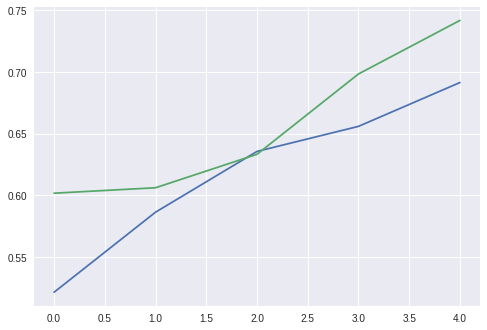

In [11]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

## Подход 1: фиксированные веса

Как мы знаем, Keras позволяет легко оперировать несколькими стандартными предобученными моделями. Мы можем использовать, например, архитектуру `VGG-19`, обученную на **ImageNet**, взяв от неё "свёрточную верхушку", которая будет по изображению выделять фичи, и затем поверх фич обучить классификатор (нейросетевой или классический), который будет осуществлять финальную классификацию.

In [17]:
vgg = keras.applications.vgg19.VGG19(weights='imagenet',include_top=False)
vgg.summary()

80142336/80134624 [==============================] - 3s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool

Вычислим выходы сети для всех изображений

In [26]:
data_gen = keras.preprocessing.image.ImageDataGenerator()
train = data_gen.flow_from_directory('training_set',shuffle=False,batch_size=20)
test = data_gen.flow_from_directory('test_set',shuffle=False,batch_size=20)
train_features = vgg.predict_generator(train,steps=2000//20)
test_features = vgg.predict_generator(test,steps=400//20)

Found 1999 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [30]:
train_labels = [0]*1000+[1]*999
test_labels = [0]*200 + [1]*200

model = keras.models.Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_features, train_labels,
          epochs=10,
          batch_size=20,
          validation_data=(test_features, test_labels))

Train on 1999 samples, validate on 400 samples
Epoch 1/10
1999/1999 [==============================] - 3s 1ms/step - loss: 3.5950 - acc: 0.7669 - val_loss: 1.1464 - val_acc: 0.9250
Epoch 2/10
1999/1999 [==============================] - 2s 822us/step - loss: 2.0671 - acc: 0.8699 - val_loss: 1.2612 - val_acc: 0.9200
Epoch 3/10
1999/1999 [==============================] - 2s 818us/step - loss: 1.5465 - acc: 0.9010 - val_loss: 1.1267 - val_acc: 0.9275
Epoch 4/10
1999/1999 [==============================] - 2s 849us/step - loss: 1.5832 - acc: 0.8979 - val_loss: 0.8601 - val_acc: 0.9450
Epoch 5/10
1999/1999 [==============================] - 2s 824us/step - loss: 1.1754 - acc: 0.9235 - val_loss: 1.4939 - val_acc: 0.9050
Epoch 6/10
1999/1999 [==============================] - 2s 814us/step - loss: 0.8717 - acc: 0.9440 - val_loss: 0.6437 - val_acc: 0.9575
Epoch 7/10
1999/1999 [==============================] - 2s 853us/step - loss: 0.7099 - acc: 0.9555 - val_loss: 0.8079 - val_acc: 0.9475
Epo

## Подход 2: Единая нейросетевая структура

На предыдущем шаге мы явно вычислили все фичи, после чего тренировали обычный классификатор уже на векторах малой размерности. Мы можем построить единую нейросеть с предобученной "верхушкой", после чего обучать её как единое целое.

Чтобы не менять веса обученных фильтров, мы "замораживаем" все слоя свёрточной верхушки, чтобы они не менялись в процессе обучения.

In [63]:
vgg = keras.applications.vgg19.VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))
for x in vgg.layers:
  x.trainable = False
model = keras.models.Sequential()
model.add(vgg)
model.add(Flatten(input_shape=train_features.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_14 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 257       
Total params: 22,122,049
Trainable params: 2,097,665
Non-trainable params: 20,024,384
_________________________________________________________________


In [64]:
data_gen = keras.preprocessing.image.ImageDataGenerator()

train_flow = data_gen.flow_from_directory('training_set',target_size=img_size,batch_size=batch_size,class_mode='binary')
test_flow = data_gen.flow_from_directory('test_set',target_size=img_size,batch_size=batch_size,class_mode='binary')

Found 1999 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [65]:
hist = model.fit_generator(train_flow,
  steps_per_epoch = train_images // batch_size,
  epochs = 5,
  validation_data = test_flow,
  validation_steps = test_images // batch_size)

Epoch 1/5
62/62 [==============================] - 12s 191ms/step - loss: 3.3150 - acc: 0.7807 - val_loss: 3.1213 - val_acc: 0.7891
Epoch 2/5
62/62 [==============================] - 9s 146ms/step - loss: 2.4171 - acc: 0.8427 - val_loss: 3.7907 - val_acc: 0.7582
Epoch 3/5
62/62 [==============================] - 9s 149ms/step - loss: 1.8724 - acc: 0.8785 - val_loss: 1.6350 - val_acc: 0.8940
Epoch 4/5
62/62 [==============================] - 9s 152ms/step - loss: 1.4288 - acc: 0.9047 - val_loss: 1.3377 - val_acc: 0.9130
Epoch 5/5
62/62 [==============================] - 9s 148ms/step - loss: 1.5379 - acc: 0.8987 - val_loss: 1.6523 - val_acc: 0.8886


### До-обучение слоёв свёрточной сети

* После того, как мы обучили классификатор, можно разморозить нижние слоя свёрточной сети

In [66]:
for x in model.layers[0].layers[19:20]:
  x.trainable = True
model.compile(optimizer=keras.optimizers.SGD(lr=1e-5, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_14 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 257       
Total params: 22,122,049
Trainable params: 4,457,473
Non-trainable params: 17,664,576
_________________________________________________________________


In [67]:
hist = model.fit_generator(train_flow,
  steps_per_epoch = train_images // batch_size,
  epochs = 5,
  validation_data = test_flow,
  validation_steps = test_images // batch_size)

Epoch 1/5
62/62 [==============================] - 12s 198ms/step - loss: 1.2992 - acc: 0.9157 - val_loss: 1.0675 - val_acc: 0.9239
Epoch 2/5
62/62 [==============================] - 9s 150ms/step - loss: 1.0193 - acc: 0.9343 - val_loss: 1.0477 - val_acc: 0.9297
Epoch 3/5
62/62 [==============================] - 9s 152ms/step - loss: 0.9859 - acc: 0.9364 - val_loss: 1.0959 - val_acc: 0.9293
Epoch 4/5
62/62 [==============================] - 9s 153ms/step - loss: 1.1870 - acc: 0.9238 - val_loss: 0.9050 - val_acc: 0.9429
Epoch 5/5
62/62 [==============================] - 10s 154ms/step - loss: 0.9606 - acc: 0.9375 - val_loss: 1.1624 - val_acc: 0.9212
